In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# np.savez('data.npz', X=X, y=y)
# Load the data from the npz file
data = np.load('data/data.npz')
X, y = data['arr_0'], data['arr_1']

X.shape, y.shape

((159132, 136), (159132,))

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Evaluate number of clusters

In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans # Good for large datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # For progress bar


# Determining the Optimal Number of Clusters (K) 
min_k = 2
max_k = 6 # You might want to explore a larger range, e.g., 2 to 20
inertia = []
silhouette_scores = []
davies_bouldin_scores = []

print("\nDetermining optimal K (Elbow Method, Silhouette, Davies-Bouldin)...")
for k in tqdm(range(min_k, max_k + 1), desc="Testing K values"):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=256)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
    # Silhouette and Davies-Bouldin can be slow for large datasets.
    # Consider sampling for these metrics if performance is an issue.
    # For large datasets, compute on a smaller, representative subset if needed.
    sample_indices = np.random.choice(X_scaled.shape[0], size=min(10000, X_scaled.shape[0]), replace=False)
    silhouette_scores.append(silhouette_score(X_scaled[sample_indices], kmeans.labels_[sample_indices]))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled[sample_indices], kmeans.labels_[sample_indices]))
    
    # For this example, we will compute on the full dataset (be aware of computation time)
    # silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    # davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))


Determining optimal K (Elbow Method, Silhouette, Davies-Bouldin)...


Testing K values: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


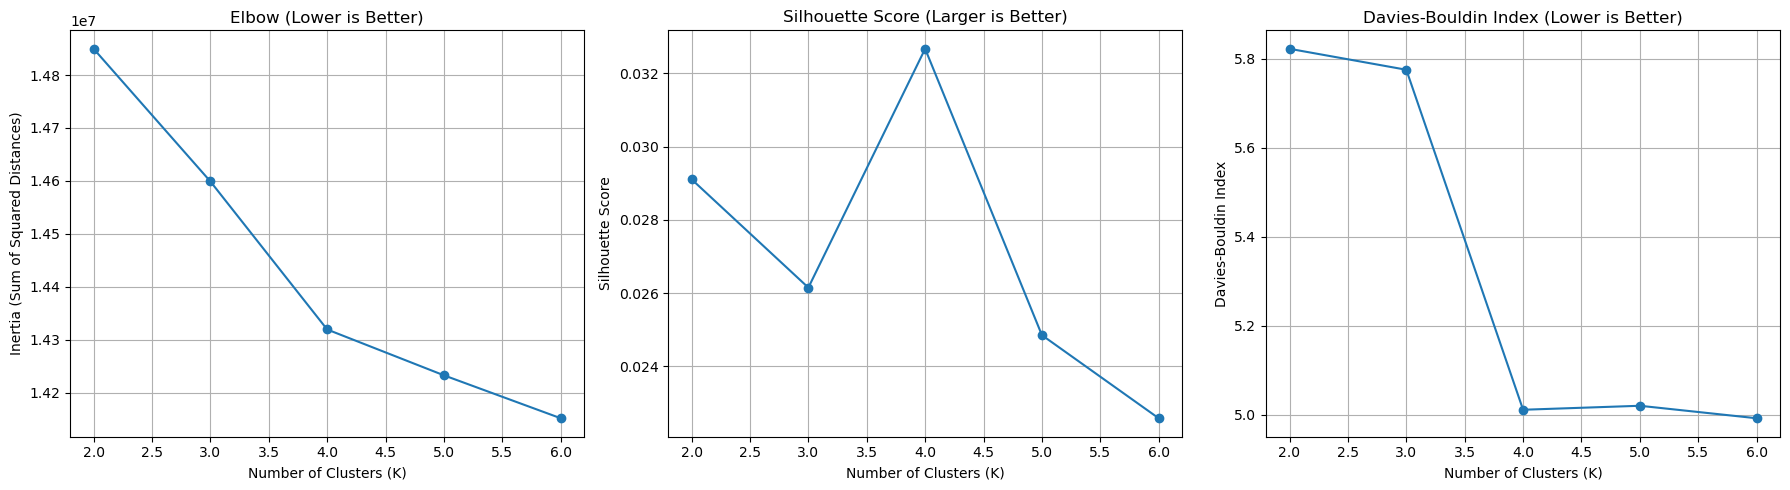

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot Elbow Method
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(min_k, max_k + 1), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow (Lower is Better)')
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(range(min_k, max_k + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score (Larger is Better)')
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(range(min_k, max_k + 1), davies_bouldin_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index (Lower is Better)')
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig(f'figures/cluster_kmeans_{min_k}-{max_k}.png')

# Evaluate the best cluster size


--- Best cluser size analysis ---

Performing MiniBatchKMeans with optimal K = 6...


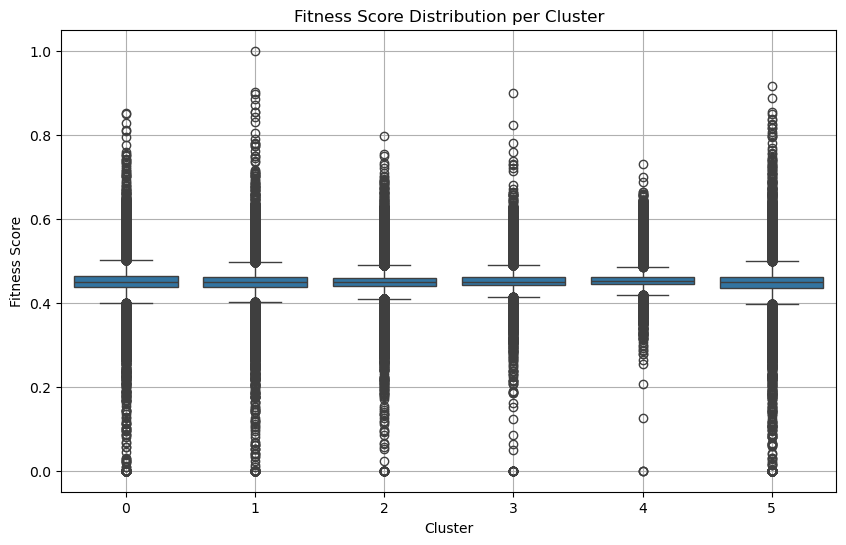

In [14]:
print("\n--- Best cluser size analysis ---")
from sklearn.cluster import MiniBatchKMeans # Good for large datasets
import matplotlib.pyplot as plt
import seaborn as sns

optimal_k = 6 # Example: derived from looking at the plots

print(f"\nPerforming MiniBatchKMeans with optimal K = {optimal_k}...")
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=10, batch_size=256)
cluster = kmeans.fit_predict(X_scaled)

df = pd.DataFrame({
    'cluster': cluster,
    'norm_fit': y,  # Assuming y is the fitness score
})

# a) Fitness Distribution per Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='norm_fit', data=df)
plt.title('Fitness Score Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fitness Score')
plt.grid(True)
plt.show()

# Visualize clusters

Comparative Analysis for 16,000 Samples
Computational Efficiency:
* PCA: Fastest, handles 16,000 samples easily (~seconds).
* UMAP: Moderately fast, manageable for 16,000 samples (~minutes with `umap-learn`).
* t-SNE: Slow, may require subsampling or optimization (~tens of minutes).
* MDS: Very slow, impractical without significant subsampling.
* Isomap: Slow, similar to MDS, less feasible for 16,000 samples.

Visualization Quality:
* UMAP and t-SNE: Best for revealing non-linear clusters (e.g., groups of variants with similar physicochemical profiles).
* PCA: Best for linear patterns and global structure but may miss non-linear clusters.
* MDS and Isomap: Good for distance preservation but less effective for cluster visualization.

Ease of Use:
* PCA: Simple, few parameters, widely available (e.g., `sklearn.decomposition.PCA`).
* UMAP: Moderate tuning (n_neighbors, min_dist), easy with `umap-learn`.
* t-SNE: Requires careful tuning of perplexity and learning rate.
* MDS and Isomap: Complex parameter tuning and slower implementations.

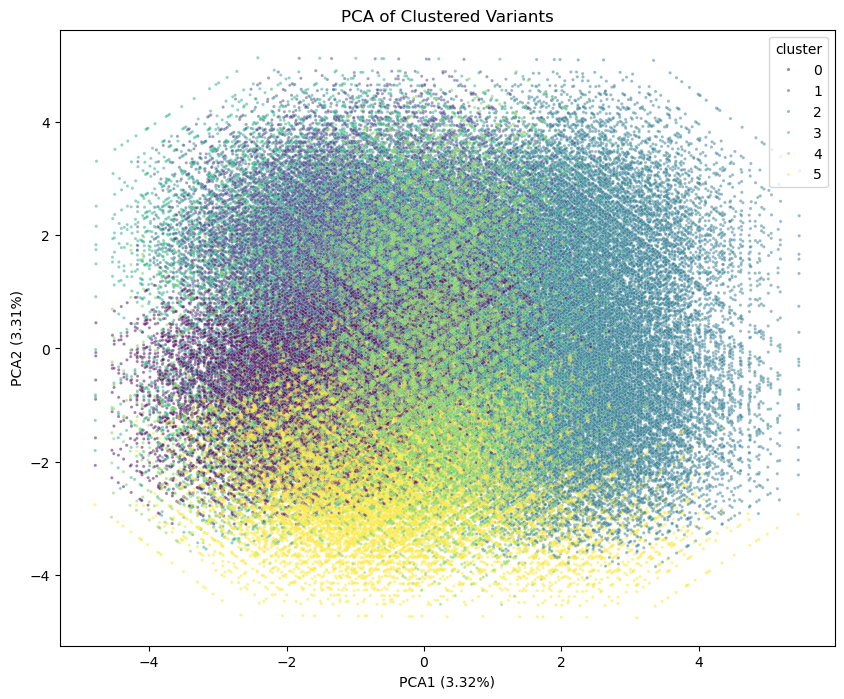


Analysis complete. Examine the plots and printed statistics to find relationships between clusters and fitness.
Look for clusters with distinct fitness profiles and associated amino acid properties/compositions.


In [15]:
# d) Dimensionality Reduction for Visualization (Optional, but highly recommended)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df, palette='viridis', legend='full', alpha=0.5, s=5)
plt.title('PCA of Clustered Variants')
plt.xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.show()

# t-SNE (can be slow for very large datasets, consider subsampling)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# X_tsne = tsne.fit_transform(X_scaled)
# df['TSNE1'] = X_tsne[:, 0]
# df['TSNE2'] = X_tsne[:, 1]

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=df, palette='viridis', legend='full', alpha=0.5, s=5)
# plt.title('t-SNE of Clustered Variants')
# plt.show()

# MDS (Multidimensional Scaling)
# mds = MDS(n_components=2, random_state=42, n_init=10, max_iter=300)
# X_mds = mds.fit_transform(X_scaled)
# df['MDS1'] = X_mds[:, 0]
# df['MDS2'] = X_mds[:, 1]    
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='MDS1', y='MDS2', hue='cluster', data=df, palette='viridis', legend='full', alpha=0.5, s=5)
# plt.title('MDS of Clustered Variants')
# plt.show()

print("\nAnalysis complete. Examine the plots and printed statistics to find relationships between clusters and fitness.")
print("Look for clusters with distinct fitness profiles and associated amino acid properties/compositions.")

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)


/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


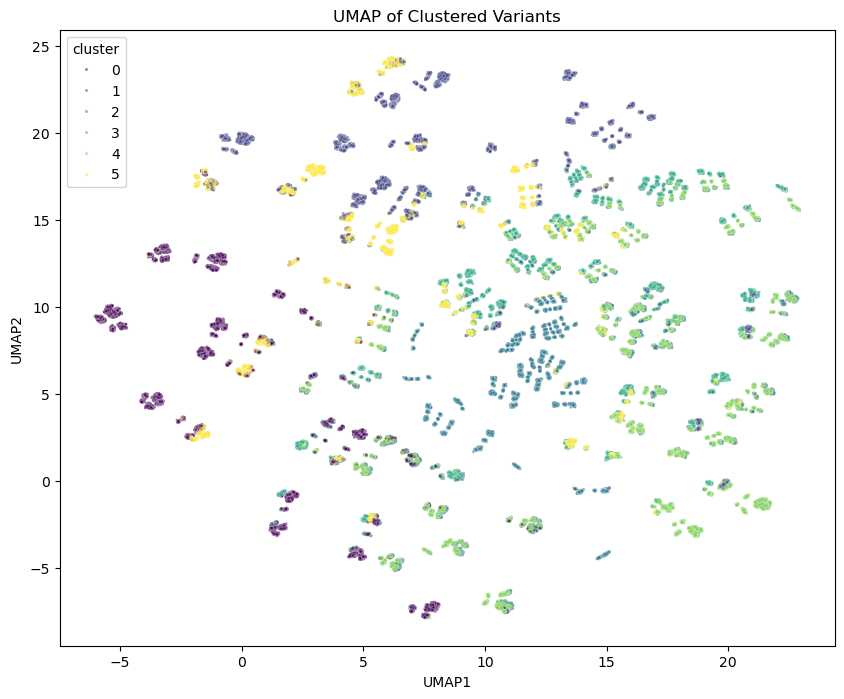

In [16]:
# ! pip install umap-learn
import umap

umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
embeddings = umap_model.fit_transform(X_scaled)
df['UMAP1'] = embeddings[:, 0]
df['UMAP2'] = embeddings[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=df, palette='viridis', legend='full', alpha=0.5, s=5)
plt.title('UMAP of Clustered Variants')
plt.show()

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


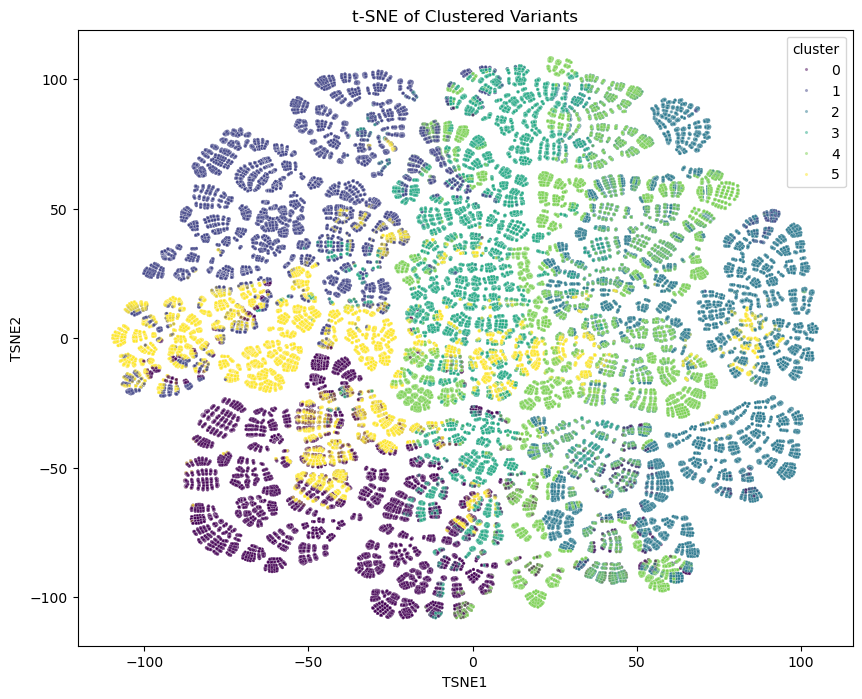

In [17]:
# t-SNE (can be slow for very large datasets, consider subsampling)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=df, palette='viridis', legend='full', alpha=0.5, s=5)
plt.title('t-SNE of Clustered Variants')
plt.show()
